In [1]:
import pandas as pd
import numpy as np

### Data Prep
**  THIS DATA PREP IS USED FOR THE MACHINE LEARNING EXERCISE, BUT IS PANDAS INTENSIVE.  MAYBE THE DATA PREP GOES IN THE PANDAS SESSION (OR NUMPY SESSION SINCE SIMILAR TRANSFORMATIONS HAPPEN THERE) **

In [2]:
# Read in the data
lobs = ['medmal','ppauto','wkcomp']
data = pd.DataFrame()
columns = ['GRCODE','GRNAME','AccidentYear','DevelopmentYear','DevelopmentLag','IncurLoss',
           'CumPaidLoss','BulkLoss','EarnedPremDIR','EarnedPremCeded','EarnedPremNet',
           'Single','PostedReserve97']
for lob in lobs:
    subset = pd.read_csv(f'https://www.casact.org/research/reserve_data/{lob}_pos.csv', names=columns, skiprows=1)
    subset['LOB'] = lob
    data = data.append(subset, sort=True)
data = data[data['DevelopmentYear']<=1997].reset_index()
data['CaseIncur'] = data['IncurLoss']-data['BulkLoss']


# Find largest 20 companies by premium size for each LOB
aggregates = (data[data['DevelopmentYear']==1997].groupby(['LOB','GRNAME']).sum()['IncurLoss']).reset_index()
top_20_by_lob = aggregates.iloc[aggregates.groupby('LOB')['IncurLoss'].nlargest(19).index.levels[1]]
data = data.merge(top_20_by_lob, how='left', on=['LOB','GRNAME'])
data.loc[data.iloc[:,-1].isna(),'GRNAME'] = 'Other'

# Create Triangles
triangles = pd.pivot_table(data, index=['GRNAME','LOB','AccidentYear'], columns='DevelopmentLag', values='CumPaidLoss', aggfunc='sum')
triangles.head(20)

DevelopmentLag                                1         2         3   \
GRNAME              LOB    AccidentYear                                
Alaska Nat Ins Co   wkcomp 1988           4386.0    7912.0    9668.0   
                           1989           5321.0   10223.0   12162.0   
                           1990           4775.0   10594.0   13524.0   
                           1991           6731.0   15173.0   18551.0   
                           1992           9166.0   18877.0   22168.0   
                           1993           8321.0   16556.0   19539.0   
                           1994           7045.0   14434.0   17173.0   
                           1995           7332.0   15222.0   18450.0   
                           1996           6599.0   12870.0       NaN   
                           1997           7048.0       NaN       NaN   
Allstate Ins Co Grp wkcomp 1988          70571.0  155905.0  220744.0   
                           1989          66547.0  136447.0  179142.0   
                           1990          52233.0  133370.0  178444.0   
                           1991          59315.0  128051.0  169793.0   
                           1992          39991.0   89873.0  114117.0   
                           1993          19744.0   47229.0   61909.0   
                           1994          20379.0   46773.0   88636.0   
                           1995          18756.0   84712.0   87311.0   
                           1996          42609.0   44916.0       NaN   
                           1997            691.0       NaN       NaN   

DevelopmentLag                                 4         5         6   \
GRNAME              LOB    AccidentYear                                 
Alaska Nat Ins Co   wkcomp 1988           10502.0   10891.0   11181.0   
                           1989           13051.0   13535.0   13734.0   
                           1990           14837.0   15353.0   15557.0   
                           1991           20392.0   21268.0   21878.0   
                           1992           23259.0   23949.0   24299.0   
                           1993           21018.0   22158.0       NaN   
                           1994           18631.0       NaN       NaN   
                           1995               NaN       NaN       NaN   
                           1996               NaN       NaN       NaN   
                           1997               NaN       NaN       NaN   
Allstate Ins Co Grp wkcomp 1988          251595.0  274156.0  287676.0   
                           1989          211343.0  231430.0  244750.0   
                           1990          204442.0  222193.0  232940.0   
                           1991          196685.0  213165.0  234676.0   
                           1992          133003.0  154362.0  159496.0   
                           1993           85099.0   87215.0       NaN   
                           1994           91077.0       NaN       NaN   
                           1995               NaN       NaN       NaN   
                           1996               NaN       NaN       NaN   
                           1997               NaN       NaN       NaN   

DevelopmentLag                                 7         8         9   \
GRNAME              LOB    AccidentYear                                 
Alaska Nat Ins Co   wkcomp 1988           11339.0   11422.0   11493.0   
                           1989           13928.0   14022.0   14108.0   
                           1990           15741.0   15882.0       NaN   
                           1991           22225.0       NaN       NaN   
                           1992               NaN       NaN       NaN   
                           1993               NaN       NaN       NaN   
                           1994               NaN       NaN       NaN   
                           1995               NaN       NaN       NaN   
                           1996               NaN       NaN       NaN   
     

In [3]:
# Determine LDF Weights
weight = np.array(~triangles.iloc[:,1:].isna())
columns = [f'{triangles.columns[num]}-{triangles.columns[num+1]}' for num, item in enumerate(triangles.columns[:-1])]

# Volume-weighted numerator and demoninator
numerator = ((weight*triangles.iloc[:,1:]).reset_index().drop('AccidentYear',axis=1).groupby(['GRNAME','LOB']).sum(axis=0))
denominator = ((weight*triangles.iloc[:,:-1]).reset_index().drop('AccidentYear',axis=1).groupby(['GRNAME','LOB']).sum(axis=0))
numerator.columns = denominator.columns = columns

# Development Patterns
ldf = (numerator/denominator).fillna(1.0)
ldf.head(10)

,,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
GRNAME,LOB,,,,,,,,,
Alaska Nat Ins Co,wkcomp,2.042044,1.204090,1.078956,1.039735,1.019448,1.014162,1.007755,1.006170,1.001740
Allstate Ins Co Grp,wkcomp,2.222958,1.337730,1.158433,1.092734,1.058643,1.045544,1.031408,1.036089,1.010920
Amerisafe Grp,wkcomp,2.083829,1.230349,1.049066,1.015398,1.011420,1.006666,1.007410,1.011116,1.013069
Associated Industries Ins Co,wkcomp,2.108629,1.353189,1.184505,1.078169,0.974303,1.034001,1.042462,1.042313,1.012176
Beacon Mut Ins Co,wkcomp,2.245266,1.342916,1.156806,1.089594,1.000000,1.000000,1.000000,1.000000,1.000000
California Cas Grp,wkcomp,2.465336,1.439107,1.211535,1.103328,1.057443,1.032072,1.020914,1.016032,1.002451
California Healthcare Ins Co Inc,medmal,6.509554,2.273835,1.709652,1.102301,1.327577,0.971001,1.128342,1.049808,1.000000
Church Mut Ins Co,wkcomp,2.150521,1.264346,1.109760,1.059074,1.030563,1.017617,1.009547,1.006784,1.010023
Clinic Mut Ins Co RRG,medmal,3.072100,1.548494,1.178165,1.112438,1.194979,0.979522,0.999304,1.000000,1.000000


# What is Scikit-Learn?

**Machine Learning in Python**

* Simple and efficient tools for data mining and data analysis
* Accessible to everybody, and reusable in various contexts
* Built on NumPy, SciPy, and matplotlib
* Open source, commercially usable - BSD license


### scikit-learn covers the majority of supervised and unsupervised ML techniques available today and  is continually expanding
![](https://scikit-learn.org/stable/_static/ml_map.png)

#### Scikit-learn is a consistent API for all Machine Learning Algorithms

Estimators are the building block of scikit-learn.  Almost everything is an estimator.  All estimators have `fit()` methods. Most have either a `predict()` or `transform()` method. Supervised techniques generally have a `score()` method as well.

The basic ML workflow looks like this:
```python
from sklearn.EstimatorFamily import Estimator
est = Estimator(hyperparameter_1, ... ,hyperparameter_n) # Create a model
est.fit(X_train, y_train) # Fit the model
est.score(X_test, y_test) # Evaluate model efficacy
est.predict(X_test) # Create predictions
```

#### Importing your estimators
`from sklearn.EstimatorFamily import Estimator` is typically how you'd import an estimator.  Some examples are:
``` python
from sklearn.linear_model import RidgeRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
```

In [4]:
# Exercise - Import the support vector classifier and a k-neighbors classifier from sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#### Hyperparameters of your estimarors (Controlling how your estimator fits)
Instantiating an estimator typically looks like `est = Estimator(hyperparameter_1, ... ,hyperparameter_n)`.
Upon instantition you have the *option* of setting hyperparameters (i.e. parameters whose values are set before the learning process).  All hyperparameters have defaults that may or may not be satisfactory for your particular problem.

Exmaples of setting initial hyperparameters on an estimator:
```python
rr = RidgeRegression(alpha=0.5, fit_intercept=False, normalize=True)
knc = KNeighborsClassifier(n_neighbors=10)
gbc = GradientBoostingClassifier()
```

In [5]:
# Exercise - Override the SVC hyperparameters such that it uses a kernel type of a second degree polynomial
SVC(kernel='poly', degree=2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Transformers - an  interim step to a final model
Several `sklearn` estimators implement a `transform()` method.  Transformers are typically used to 'transform' your featureset in a way that will improve another algorithms (e.g. regressor, classifier) performance.

Typical examples include:
```python
sklearn.preprocessing.PCA # Principle Components transformation
sklearn.preprocessing.OneHotEncoder # Categorical to dummy transformation
sklearn.preprocessing.StandardScaler # Removing the mean and scaling to unit variance for each feature
sklearn.preprocessing.LabelEncoder # Single-column label to integer tranformation
```

In [6]:
# Exercise - Import and create a labelEncoder transformer named 'le'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Fitting an estimator
To fit an estimator we require data - in most cases the data must be `numpy` arrays that are numeric in nature. However, many of the preprocessing transformers are helpers designed to meet this requirement.

In [7]:
response = ldf.reset_index()['LOB']
# Exercise - Pass 'response'to the fit method of your LabelEncoder() instance you created in the previous exercise.
le.fit(response)

LabelEncoder()

#### Mutating the Estimator with fit()
Though it looks like nothing happened, a lot happened under the hood.  Our estimator has seen data can now be applied to new datasets.  Once an estimator is fit, it spin off useful metadata that describes the fit model.  `sklearn` uses a trailing underscore in property names to help users distinguish between hyperparameters and the new metadata.
```python
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
print(lr.fit_intercept) # A hyperparameter.  Returns False.
print(lr.coef_) # Trailing underscore denotes the property comes from a 'fit'.  Returns model coefficients.
```

In [8]:
# Exercise - access the 'classes_' property of our label encoder.
le.classes_

array(['medmal', 'ppauto', 'wkcomp'], dtype=object)

#### Predicting/Transforming a dataset
With a fit estimator we can create predictions or transformations on any new dataset that has the same number of features as our original data.

In [9]:
# Exercise -  create an array called 'y' that uses your LabelEncoder transform() method on 'response'
y = le.transform(response)
y

array([2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1,
       1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 0, 0, 2,
       0, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 2], dtype=int64)

### Supervised Learning Example - Identifying the line of business of an unlabeled triangle
We've computed the development patterns of twenty companies for `wkcomp`, `comauto`, and `ppauto`.
The LDFs are our featureset **X**, and the known line of business is our response, **y**.

Train Model > Validate performance on Test > Make Preditions

#### Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split
X = ldf.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Fitting our classifier

In [11]:
# Exercise - Create a KNeighborsClassifier and fit it to our training data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### Evaluating our classifier
The `score()` method of all classifiers defaults to an accuracy measure.  

In [12]:
# Exercise - Use score() to evaluate the accuracy of our KNeighborsClassifier on our test set.
knn.score(X_test,y_test)

0.85

##### Classifier Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, knn.predict(X_test)), index=le.classes_, columns=le.classes_)

,medmal,ppauto,wkcomp
medmal,3,0,1
ppauto,0,6,2
wkcomp,0,0,8


##### Visual representation of first three Development Factors
By inspection (at least across the first three development ages), it is difficult to distinguish between `wkcomp` and `ppauto` in line with where our `KNeighborsClassifier` was least accurate.

C:\Users\jbogaard\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


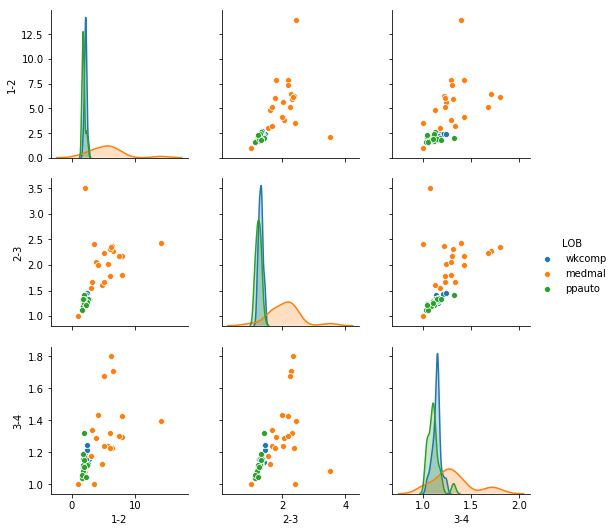

In [14]:
import seaborn as sns
%matplotlib inline
g = sns.pairplot(ldf.reset_index()[['LOB','1-2','2-3','3-4']], hue="LOB")

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)
# Exercise - What is our accuracy when we change our train_test_split random_state to 41?
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test,y_test)

0.65

##### Cross-validation
`sklearn` provides a `cross_val_score` to test the robustness of an estimator across multiple folds painting a truer picture of an estimators' efficacy than a simple train/test split.

In [16]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(knn, X, y))

0.8359788359788359

#### Improving model accuracy with GridSearchCV

With `GridSearchCV`, we can feed a hyperparameter grid into our estimator to determine an 'optimal' set of hyperparameters to use for our particular business problem.  `GridSearchCV` itself is an estimator and so it has the usual `'fit()` and `predict()` methods any other classifier would.

At a minimum, parameterizing the GridSearchCV estimator we need to specify:
1. The estimator we want to use
2. The hyperparameter searchspace as a dictionary

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_neighbors':[1,3,5,7,9,11]}
grid = GridSearchCV(knn, param_grid, return_train_score=True)
grid.fit(X, y)
print(f'Best Score: {grid.best_score_}')
grid.best_estimator_

Best Score: 0.8333333333333334


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

A Visual inspection of the cross-validated scores shows strong support for `n_neighbors=5`

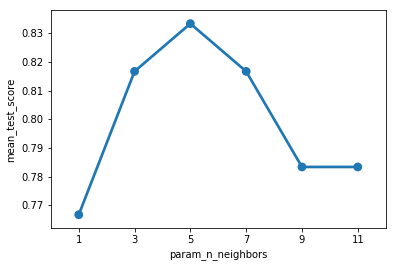

In [18]:
g = sns.pointplot(x='param_n_neighbors', y='mean_test_score', data=pd.DataFrame(grid.cv_results_))

In [19]:
# Exercise - Explore values of KNeighborsClassifier hyperparameter, p to improve the cross-validated score of our estimator
param_grid=dict(n_neighbors=[1,3,5,7,9,11], p=[1,2,3,4,5,6])
grid = GridSearchCV(knn, param_grid, return_train_score=True)
grid.fit(X, y)
print(f'Best Score: {grid.best_score_}')
grid.best_estimator_

Best Score: 0.8666666666666667


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=5,
           weights='uniform')

In [20]:
# Exercise - Display the confusion matrix of your best estimator from the previous exercise on the entire dataset
pd.DataFrame(confusion_matrix(y, grid.best_estimator_.predict(X)), index=le.classes_, columns=le.classes_)

,medmal,ppauto,wkcomp
medmal,19,1,0
ppauto,0,16,4
wkcomp,0,2,18


### Further Reading - Pipelines
Pipelines are useful for chaining one or more transformers together with an estimator (e.g. regressor, classifier) as the final step.  Pipelines themselves are estimators and have `fit()`, `predict()`, and `score()` function.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_boston

# Regression Dataset
boston = load_boston()

X_train, X_test, y_train, y_test = \
    train_test_split(boston['data'], boston['target'], 
                     test_size=0.33, random_state=42)
    

poly = PolynomialFeatures(degree=4) # Transformer
dtree = DecisionTreeRegressor(random_state=42) # Regressor
pipe = Pipeline(steps=[('poly', poly), ('dtree', dtree)]) # Pipeline chains the steps together

# Usual fit/score routines 
pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

0.8085432444660042

The real power in pipelines is that the hyperparameter space of all estimators in the pipeline can be gridsearched.  To avoid hyperparameter name clashes between one estimator and another, sklearn uses an {estimator_name}__hyperparameter notation for the keys of its parameter grid.

See Example:

In [31]:
param_grid = dict(dtree__criterion =['mse','friedman_mse'],
                  dtree__max_depth = [25, 50, 75, 100],
                  dtree__min_samples_leaf =[2, 3, 5, 10],
                  dtree__min_samples_split = [5,10,20],
                  poly__degree=[1,2])

optimized_pipeline = GridSearchCV(pipe, param_grid, cv=5, refit=True)
optimized_pipeline.fit(X_train, y_train)

print(f'Optimal parameter set produces a holdout score of {optimized_pipeline.score(X_test,y_test)}')
optimized_pipeline.best_estimator_

Optimal parameter set produces a holdout score of 0.8198128089350925


Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('dtree', DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'))])